In [0]:
# =============================================================================
# TRABAJO PRÁCTICO: ANÁLISIS DE PELÍCULAS TMDb CON APACHE SPARK Y DATABRICKS
# Grupo: Chirino Francisco, Dominguez Guadalupe, Funes Gonzalo, De Biazi Jerónimo.
# =============================================================================

## Índice de Contenidos
#  1. Configuración del Entorno
#  2. Carga y Exploración de Datos
#  3. Transformaciones de Datos
#  4. Almacenamiento con Delta Lake
#  5. Visualización y Análisis

In [0]:
# ETAPA 1: Configuración del Entorno
#En esta sección verificamos la conexión con Spark y preparamos el entorno.

In [0]:
print("¡Hola Databricks!")
print(f"Versión de Spark: {spark.version}")

¡Hola Databricks!
Versión de Spark: 4.0.0


In [0]:
# Consulta SQL desde Python
display(spark.sql("SELECT 'Prueba SQL' as mensaje, current_date() as fecha"))

mensaje,fecha
Prueba SQL,2025-11-15


In [0]:
#ETAPA 2: Carga y Exploración de Datos
#Cargamos el dataset de películas de TMDb y realizamos un análisis exploratorio inicial para entender la estructura y calidad de los datos.

In [0]:
# 2.1 - Cargar dataset de películas desde TMDb

In [0]:

import pandas as pd
# Descargamos el dataset desde GitHub y lo convertimos a Spark DataFrame para aprovechar el procesamiento distribuido de Apache Spark
url = "https://raw.githubusercontent.com/danielgrijalva/movie-stats/master/movies.csv" 
# Cargamos con Pandas primero (más fácil para archivos web)
df_pandas = pd.read_csv(url)
# Convertimos a Spark DataFrame para procesamiento escalable
df = spark.createDataFrame(df_pandas)

# Verificamos la carga
print(f"✅ Dataset de películas cargado: {df.count()} filas") #Cantidad de filas
print(f"✅ Columnas: {len(df.columns)}") #Cantidad de columnas
print("\n=== PRIMERAS 5 PELÍCULAS ===")
display(df.limit(5))

✅ Dataset de películas cargado: 7668 filas
✅ Columnas: 15

=== PRIMERAS 5 PELÍCULAS ===


name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,1.9E7,4.6998772E7,Warner Bros.,146.0
The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,5.8853106E7,Columbia Pictures,104.0
Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,1.8E7,5.38375067E8,Lucasfilm,124.0
Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,8.3453539E7,Paramount Pictures,88.0
Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,3.9846344E7,Orion Pictures,98.0


In [0]:
# 2.2 - Exploración de la Estructura

In [0]:
# Ver estructura completa del DataFrame
print("=== ESQUEMA DE DATOS ===")
df.printSchema() #muestra el tipo de dato de cada columna (string, integer, double, etc.) para saber qué operaciones podemos hacer con cada columna

# Listamos todas las columnas disponibles en el dataset
print("\n=== COLUMNAS DISPONIBLES ===")
# El bucle for recorre cada nombre de columna y lo imprime con formato
for col in df.columns:
    print(f"  • {col}")

=== ESQUEMA DE DATOS ===
root
 |-- name: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: long (nullable = true)
 |-- released: string (nullable = true)
 |-- score: double (nullable = true)
 |-- votes: double (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- star: string (nullable = true)
 |-- country: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- gross: double (nullable = true)
 |-- company: string (nullable = true)
 |-- runtime: double (nullable = true)


=== COLUMNAS DISPONIBLES ===
  • name
  • rating
  • genre
  • year
  • released
  • score
  • votes
  • director
  • writer
  • star
  • country
  • budget
  • gross
  • company
  • runtime


In [0]:
# Ver información detallada de las primeras 10 películas
print("=== MUESTRA DE DATOS ===")
display(df.limit(10))

=== MUESTRA DE DATOS ===


name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,1.9E7,4.6998772E7,Warner Bros.,146.0
The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,5.8853106E7,Columbia Pictures,104.0
Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,1.8E7,5.38375067E8,Lucasfilm,124.0
Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,8.3453539E7,Paramount Pictures,88.0
Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,3.9846344E7,Orion Pictures,98.0
Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,3.9754601E7,Paramount Pictures,95.0
The Blues Brothers,R,Action,1980,"June 20, 1980 (United States)",7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,2.7E7,1.1522989E8,Universal Pictures,133.0
Raging Bull,R,Biography,1980,"December 19, 1980 (United States)",8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,1.8E7,2.3402427E7,Chartoff-Winkler Productions,129.0
Superman II,PG,Action,1980,"June 19, 1981 (United States)",6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,5.4E7,1.08185706E8,Dovemead Films,127.0
The Long Riders,R,Biography,1980,"May 16, 1980 (United States)",7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,1.0E7,1.5795189E7,United Artists,100.0


In [0]:
# Contar total de registros
print(f"Total de películas en el dataset: {df.count()}") ## count() devuelve el número total de filas en el dataset

# Estadísticas descriptivas de columnas numéricas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
display(df.describe()) # describe() calcula: count, mean (promedio), stddev (desviación), min y max. Solo funciona con columnas numéricas (ignora las de texto automáticamente)

Total de películas en el dataset: 7668

=== ESTADÍSTICAS DESCRIPTIVAS ===


summary,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
count,7668,7591,7668,7668,7666,7665,7665,7668,7665,7667,7665,5497,7479,7651,7664
mean,Infinity,null,null,2000.4054512258738,null,6.390410958904108,88108.50476190477,null,null,null,null,3.5589876192650534E7,7.850054101778312E7,null,107.2616127348643
stddev,NaN,null,null,11.153507842980881,null,0.9688416402530589,163323.76390950623,null,null,null,null,4.145729660193098E7,1.657251243187572E8,null,18.581247313480578
min,'71,Approved,Action,1980,1981 (United States),1.9,7.0,A.R. Murugadoss,'Weird Al' Yankovic,'Weird Al' Yankovic,Argentina,3000.0,309.0,"""DIA"" Productions GmbH & Co. KG",55.0
max,Æon Flux,X,Western,2020,"September 9, 2016 (United States)",9.3,2400000.0,Éva Gárdos,Éva Gárdos,Émilie Dequenne,Yugoslavia,3.56E8,2.847246203E9,thefyzz,366.0


In [0]:
# 2.3 - Consultas Exploratorias con Spark SQL

In [0]:
# Crear una vista temporal para usar SQL
df.createOrReplaceTempView("peliculas") #createOrReplaceTempView() registra el DataFrame como tabla SQL temporal
# "peliculas" es el nombre del dataframe que voy a usar para hacer consultas en SQL
print("✅ Vista temporal 'peliculas' creada")

✅ Vista temporal 'peliculas' creada


In [0]:
# Consulta 1: Ver todos los géneros disponibles

# DISTINCT elimina duplicados, mostrando cada género solo una vez
# WHERE genre IS NOT NULL filtra valores vacíos
# ORDER BY genre ordena alfabéticamente
display(spark.sql("""
    SELECT DISTINCT genre 
    FROM peliculas
    WHERE genre IS NOT NULL
    ORDER BY genre
"""))

genre
Action
Adventure
Animation
Biography
Comedy
Crime
Drama
Family
Fantasy
History


In [0]:
# Consulta 2: Cantidad de películas por género

# GROUP BY genre agrupa las películas por género
# COUNT(*) cuenta cuántas películas hay en cada grupo
# ORDER BY cantidad DESC ordena de mayor a menor cantidad
# LIMIT 10 muestra solo los 10 géneros con más películas
display(spark.sql("""
    SELECT genre, COUNT(*) as cantidad
    FROM peliculas
    WHERE genre IS NOT NULL
    GROUP BY genre
    ORDER BY cantidad DESC
    LIMIT 10
"""))

genre,cantidad
Comedy,2245
Action,1705
Drama,1518
Crime,551
Biography,443
Adventure,427
Animation,338
Horror,322
Fantasy,44
Mystery,20


In [0]:
# Consulta 3: Películas mejor calificadas

# WHERE score IS NOT NULL filtra películas sin calificación
# ORDER BY score DESC ordena de mayor a menor puntuación
# LIMIT 10 muestra solo las 10 mejores películas
display(spark.sql("""
    SELECT name, year, score, rating, genre
    FROM peliculas
    WHERE score IS NOT NULL
    ORDER BY score DESC
    LIMIT 10
"""))

name,year,score,rating,genre
The Shawshank Redemption,1994,9.3,R,Drama
The Dark Knight,2008,9.0,PG-13,Action
Schindler's List,1993,8.9,R,Biography
Pulp Fiction,1994,8.9,R,Crime
The Lord of the Rings: The Return of the King,2003,8.9,PG-13,Action
Forrest Gump,1994,8.8,PG-13,Drama
Fight Club,1999,8.8,R,Drama
Inception,2010,8.8,PG-13,Action
The Lord of the Rings: The Fellowship of the Ring,2001,8.8,PG-13,Action
Star Wars: Episode V - The Empire Strikes Back,1980,8.7,PG,Action


In [0]:
# Consulta 4: Estadísticas por década

# FLOOR(year/10)*10 convierte el año en década (ej: 2015 → 2010, 1998 → 1990)
# AVG(score) calcula el promedio de calificación por década
# AVG(gross)/1000000 convierte la recaudación promedio a millones
# GROUP BY decada agrupa todas las películas de cada década
# ORDER BY decada DESC muestra desde la década más reciente
display(spark.sql("""
    SELECT 
        FLOOR(year/10)*10 as decada,
        COUNT(*) as cantidad_peliculas,
        ROUND(AVG(score), 2) as score_promedio,
        ROUND(AVG(gross)/1000000, 2) as recaudacion_promedio_millones
    FROM peliculas
    WHERE year IS NOT NULL AND score IS NOT NULL
    GROUP BY FLOOR(year/10)*10
    ORDER BY decada DESC
"""))

decada,cantidad_peliculas,score_promedio,recaudacion_promedio_millones
2020,22,5.97,189.89
2010,2000,6.52,134.79
2000,2000,6.42,92.48
1990,2000,6.38,48.33
1980,1643,6.22,24.18


In [0]:
#ETAPA 3: Transformaciones de Datos
#Limpiamos los datos y creamos nuevas columnas calculadas para el análisis.

In [0]:
# 3.1 - Análisis de Calidad de Datos

In [0]:
# Verificar valores nulos en cada columna
from pyspark.sql.functions import col, count, when #Funciones necesarias dePySpark

# Con el bucle recorremos todas las columnas y creamos una expresión de conteo para cada una
print("=== ANÁLISIS DE VALORES NULOS ===")
null_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c) #cuenta solo los valores NULL de cada columna
    for c in df.columns
])
display(null_counts) #muestra las columnas que tienen elementos vacios

=== ANÁLISIS DE VALORES NULOS ===


name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,77,0,0,2,3,3,0,3,1,3,2171,189,17,4


In [0]:
# Análisis detallado de completitud de datos: Calcular porcentaje de datos completos por columna

total_rows = df.count()

print(f"Total de películas: {total_rows}\n")
print("=== COMPLETITUD DE DATOS ===")

# Para cada columna, calculamos cuántos valores nulos hay y qué porcentaje está completo
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count() #cuenta valores nulos
    completeness = ((total_rows - null_count) / total_rows) * 100 # calcula % completo
    print(f"{column:20} → {completeness:.1f}% completo ({null_count} nulos)")

Total de películas: 7668

=== COMPLETITUD DE DATOS ===
name                 → 100.0% completo (0 nulos)
rating               → 99.0% completo (77 nulos)
genre                → 100.0% completo (0 nulos)
year                 → 100.0% completo (0 nulos)
released             → 100.0% completo (2 nulos)
score                → 100.0% completo (3 nulos)
votes                → 100.0% completo (3 nulos)
director             → 100.0% completo (0 nulos)
writer               → 100.0% completo (3 nulos)
star                 → 100.0% completo (1 nulos)
country              → 100.0% completo (3 nulos)
budget               → 71.7% completo (2171 nulos)
gross                → 97.5% completo (189 nulos)
company              → 99.8% completo (17 nulos)
runtime              → 99.9% completo (4 nulos)


In [0]:
# 3.2 - Limpieza de Datos

In [0]:

# Eliminar duplicados
df_limpio = df.dropDuplicates()
print(f"✅ Filas originales: {df.count()}")
print(f"✅ Filas después de eliminar duplicados: {df_limpio.count()}") #mostramos la cantidad de filas despues de borrar las duplicados
print(f"✅ Duplicados eliminados: {df.count() - df_limpio.count()}")

✅ Filas originales: 7668
✅ Filas después de eliminar duplicados: 7668
✅ Duplicados eliminados: 0


In [0]:

# Eliminar películas sin información básica. Resultado: 3 peliculas sin los datos basicos

# El operador & significa "Y" - deben cumplirse las 3 condiciones
# isNotNull() verifica que el valor NO sea nulo (vacío)
df_limpio = df_limpio.filter( 
    col("name").isNotNull() & 
    col("year").isNotNull() & 
    col("score").isNotNull()
)

print(f"✅ Películas con datos completos básicos: {df_limpio.count()}")
display(df_limpio.limit(5))

✅ Películas con datos completos básicos: 7665


name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
Mommie Dearest,R,Biography,1981,"September 25, 1981 (United States)",6.7,15000.0,Frank Perry,Christina Crawford,Faye Dunaway,United States,5000000.0,1.9032261E7,Paramount Pictures,129.0
Stroker Ace,PG,Action,1983,"July 1, 1983 (United States)",4.9,3700.0,Hal Needham,William Neely,Burt Reynolds,United States,null,1.3E7,Universal Pictures,96.0
Flashdance,R,Drama,1983,"April 15, 1983 (United States)",6.2,50000.0,Adrian Lyne,Thomas Hedley Jr.,Jennifer Beals,United States,4000000.0,9.2921203E7,Paramount Pictures,95.0
Ghostbusters,PG,Action,1984,"June 8, 1984 (United States)",7.8,365000.0,Ivan Reitman,Dan Aykroyd,Bill Murray,United States,3.0E7,2.96187079E8,Columbia Pictures,105.0
"Oh, God! You Devil",PG,Comedy,1984,"November 9, 1984 (United States)",5.4,2400.0,Paul Bogart,Andrew Bergman,George Burns,United States,null,2.153885E7,Warner Bros.,97.0


In [0]:
# 3.3 - Crear Columnas Calculadas

In [0]:
# Crear nuevas columnas con métricas financieras calculadas
from pyspark.sql.functions import round as spark_round, when

df_transformado = df_limpio.withColumn(
    "profit",  # Ganancia = Recaudación - Presupuesto
    col("gross") - col("budget")
).withColumn(
    "roi_percentage",  # ROI = (Ganancia / Presupuesto) * 100
    when(col("budget") > 0,  # Solo si hay presupuesto (evita división por cero)
         spark_round((col("gross") - col("budget")) / col("budget") * 100, 2)
    ).otherwise(None)  # Si no hay presupuesto, retorna NULL
).withColumn(
    "budget_millions",  # Convertir presupuesto a millones
    spark_round(col("budget") / 1000000, 2)
).withColumn(
    "gross_millions",  # Convertir recaudación a millones
    spark_round(col("gross") / 1000000, 2)
).withColumn(
    "profit_millions",  # Convertir ganancia a millones
    spark_round(col("profit") / 1000000, 2)
)

print("✅ Nuevas columnas creadas:")
print("  • profit: Ganancia neta (gross - budget)")
print("  • roi_percentage: Retorno de inversión en %")
print("  • budget_millions: Presupuesto en millones")
print("  • gross_millions: Recaudación en millones")
print("  • profit_millions: Ganancia en millones")

✅ Nuevas columnas creadas:
  • profit: Ganancia neta (gross - budget)
  • roi_percentage: Retorno de inversión en %
  • budget_millions: Presupuesto en millones
  • gross_millions: Recaudación en millones
  • profit_millions: Ganancia en millones


In [0]:
# Ver las nuevas columnas
display(df_transformado.select(
    "name", "year", "budget_millions", "gross_millions", 
    "profit_millions", "roi_percentage"
).limit(10))

name,year,budget_millions,gross_millions,profit_millions,roi_percentage
Mommie Dearest,1981,5.0,19.03,14.03,280.65
Stroker Ace,1983,null,13.0,null,null
Flashdance,1983,4.0,92.92,88.92,2223.03
Ghostbusters,1984,30.0,296.19,266.19,887.29
"Oh, God! You Devil",1984,null,21.54,null,null
The Hand,1981,null,2.45,null,null
Petit Con,1984,null,0.13,null,null
Educating Rita,1983,null,14.65,null,null
F/X,1986,10.0,20.6,10.6,106.04
Twilight Zone: The Movie,1983,10.0,29.45,19.45,194.51


In [0]:
# Clasificar películas en categorías según calidad y recaudación
df_transformado = df_transformado.withColumn(
    "categoria_score",  # Categoría según calificación
    when(col("score") >= 8.0, "Excelente")  # Score 8.0 o más
    .when(col("score") >= 7.0, "Muy buena")  # Score entre 7.0 y 7.9
    .when(col("score") >= 6.0, "Buena")      # Score entre 6.0 y 6.9
    .when(col("score") >= 5.0, "Regular")    # Score entre 5.0 y 5.9
    .otherwise("Mala")                        # Score menor a 5.0
).withColumn(
    "categoria_recaudacion",  # Categoría según recaudación
    when(col("gross") >= 500000000, "Blockbuster")   # $500M o más
    .when(col("gross") >= 100000000, "Muy exitosa")  # $100M - $500M
    .when(col("gross") >= 50000000, "Exitosa")       # $50M - $100M
    .when(col("gross") >= 10000000, "Moderada")      # $10M - $50M
    .otherwise("Baja")                                # Menos de $10M
)

print("=== PELÍCULAS CLASIFICADAS ===")
display(df_transformado.select(
    "name", "score", "categoria_score", 
    "gross_millions", "categoria_recaudacion"
).limit(10))

=== PELÍCULAS CLASIFICADAS ===


name,score,categoria_score,gross_millions,categoria_recaudacion
Mommie Dearest,6.7,Buena,19.03,Moderada
Stroker Ace,4.9,Mala,13.0,Moderada
Flashdance,6.2,Buena,92.92,Exitosa
Ghostbusters,7.8,Muy buena,296.19,Muy exitosa
"Oh, God! You Devil",5.4,Regular,21.54,Moderada
The Hand,5.5,Regular,2.45,Baja
Petit Con,6.2,Buena,0.13,Baja
Educating Rita,7.2,Muy buena,14.65,Moderada
F/X,6.7,Buena,20.6,Moderada
Twilight Zone: The Movie,6.5,Buena,29.45,Moderada


In [0]:
# 3.4 - Aplicar Filtros

In [0]:
# Filtro 1: Películas exitosas (buena calificación Y alta recaudación)
df_exitosas = df_transformado.filter(
    (col("score") > 7.5) & (col("gross") > 100000000)
)

print(f"✅ Películas exitosas (score > 7.5 Y recaudación > $100M): {df_exitosas.count()}")
display(df_exitosas.select("name", "year", "genre", "score", "gross_millions").limit(10))

✅ Películas exitosas (score > 7.5 Y recaudación > $100M): 279


name,year,genre,score,gross_millions
Star Wars: Episode V - The Empire Strikes Back,1980,Action,8.7,538.38
The Blues Brothers,1980,Action,7.9,115.23
Indiana Jones and the Raiders of the Lost Ark,1981,Action,8.4,389.93
On Golden Pond,1981,Drama,7.6,119.29
E.T. the Extra-Terrestrial,1982,Family,7.8,792.91
First Blood,1982,Action,7.7,125.21
Star Wars: Episode VI - Return of the Jedi,1983,Action,8.3,475.11
Ghostbusters,1984,Action,7.8,296.19
Back to the Future,1985,Adventure,8.5,381.91
Aliens,1986,Action,8.3,131.06


In [0]:
# Filtro 2: Películas modernas (después del 2000)
df_modernas = df_transformado.filter(col("year") >= 2000)

print(f"✅ Películas del 2000 en adelante: {df_modernas.count()}")
display(df_modernas.limit(10))

✅ Películas del 2000 en adelante: 4022


name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,roi_percentage,budget_millions,gross_millions,profit_millions,categoria_score,categoria_recaudacion
Dinosaur,PG,Animation,2000,"May 19, 2000 (United States)",6.5,56000.0,Eric Leighton,Thom Enriquez,D.B. Sweeney,United States,1.275E8,3.49822765E8,Walt Disney Pictures,82.0,2.22322765E8,174.37,127.5,349.82,222.32,Buena,Muy exitosa
America's Sweethearts,PG-13,Comedy,2001,"July 20, 2001 (United States)",5.7,55000.0,Joe Roth,Billy Crystal,Julia Roberts,United States,4.6E7,1.38307673E8,Revolution Studios,102.0,9.2307673E7,200.67,46.0,138.31,92.31,Regular,Muy exitosa
Scarlet Diva,R,Drama,2000,"May 26, 2000 (Italy)",5.0,2400.0,Asia Argento,Asia Argento,Asia Argento,Italy,null,18062.0,Opera Film (II),90.0,null,null,null,0.02,null,Regular,Baja
Queen of the Damned,R,Drama,2002,"February 22, 2002 (United States)",5.3,53000.0,Michael Rymer,Anne Rice,Aaliyah,United States,3.5E7,4.547911E7,Warner Bros.,101.0,1.047911E7,29.94,35.0,45.48,10.48,Regular,Moderada
Malena,R,Comedy,2000,"February 2, 2001 (United States)",7.5,94000.0,Giuseppe Tornatore,Giuseppe Tornatore,Monica Bellucci,Italy,null,1.4493284E7,Medusa Film,108.0,null,null,null,14.49,null,Muy buena,Moderada
Driven,PG-13,Action,2001,"April 27, 2001 (United States)",4.6,40000.0,Renny Harlin,Jan Skrentny,Sylvester Stallone,United States,9.4E7,5.4744738E7,Franchise Pictures,116.0,-3.9255262E7,-41.76,94.0,54.74,-39.26,Mala,Exitosa
The Hours,PG-13,Drama,2002,"February 14, 2003 (United States)",7.5,127000.0,Stephen Daldry,Michael Cunningham,Meryl Streep,United States,2.5E7,1.08846072E8,Paramount Pictures,110.0,8.3846072E7,335.38,25.0,108.85,83.85,Muy buena,Muy exitosa
Cats & Dogs,PG,Action,2001,"July 4, 2001 (United States)",5.1,57000.0,Lawrence Guterman,John Requa,Alec Baldwin,United States,6.0E7,2.00687492E8,Warner Bros.,87.0,1.40687492E8,234.48,60.0,200.69,140.69,Regular,Muy exitosa
The Musketeer,PG-13,Action,2001,"September 7, 2001 (United States)",4.8,14000.0,Peter Hyams,Alexandre Dumas,Justin Chambers,Germany,4.0E7,3.2533802E7,Centurion,104.0,-7466198.0,-18.67,40.0,32.53,-7.47,Mala,Moderada
I Spy,PG-13,Action,2002,"November 1, 2002 (United States)",5.4,50000.0,Betty Thomas,Morton S. Fine,Eddie Murphy,United States,7.0E7,5.1386477E7,Columbia Pictures,97.0,-1.8613523E7,-26.59,70.0,51.39,-18.61,Regular,Exitosa


In [0]:
# Filtro 3: Blockbusters rentables (alta recaudación Y alto retorno de inversión)
# ROI > 100% significa que duplicaron o más su inversión
df_blockbusters = df_transformado.filter(
    (col("gross") > 500000000) & (col("roi_percentage") > 100)
)

print(f"✅ Blockbusters rentables (recaudación > $500M y ROI > 100%): {df_blockbusters.count()}")
display(df_blockbusters.select(
    "name", "year", "gross_millions", "budget_millions", "roi_percentage"
).orderBy(col("roi_percentage").desc()))

✅ Blockbusters rentables (recaudación > $500M y ROI > 100%): 205


name,year,gross_millions,budget_millions,roi_percentage
E.T. the Extra-Terrestrial,1982,792.91,10.5,7451.53
Star Wars: Episode V - The Empire Strikes Back,1980,538.38,18.0,2890.97
The Lion King,1994,1083.72,45.0,2308.27
Ghost,1990,505.7,22.0,2198.65
The Passion of the Christ,2004,612.05,30.0,1940.18
It,2017,701.8,35.0,1905.13
Joker,2019,1074.43,55.0,1853.5
Aladdin,1992,504.05,28.0,1700.18
Bohemian Rhapsody,2018,911.9,52.0,1653.66
The Sixth Sense,1999,672.81,40.0,1582.02


In [0]:
# 3.5 - Agregaciones

In [0]:
# Agregación 1: Calcular estadísticas agrupadas por género cinematográfico
from pyspark.sql.functions import avg, max, min, sum

df_por_genero = df_transformado.groupBy("genre").agg(
    count("*").alias("cantidad_peliculas"),  # Contamos cuántas películas hay de cada género
    spark_round(avg("score"), 2).alias("score_promedio"),  # Calculamos el promedio de calificación
    spark_round(avg("gross_millions"), 2).alias("recaudacion_promedio_M"),  # Promedio de recaudación
    spark_round(sum("gross_millions"), 2).alias("recaudacion_total_M"),  # Sumamos el total de recaudación
    spark_round(avg("budget_millions"), 2).alias("presupuesto_promedio_M")  # Promedio de presupuesto
).orderBy(col("cantidad_peliculas").desc())  # Ordenamos por cantidad de películas (de mayor a menor)

print("=== ANÁLISIS POR GÉNERO ===")
display(df_por_genero)

=== ANÁLISIS POR GÉNERO ===


genre,cantidad_peliculas,score_promedio,recaudacion_promedio_M,recaudacion_total_M,presupuesto_promedio_M
Comedy,2245,6.19,44.33,97175.51,22.61
Action,1704,6.2,145.51,243435.79,58.13
Drama,1516,6.69,38.93,57150.76,22.97
Crime,551,6.67,39.4,21355.41,22.36
Biography,443,7.03,47.87,20729.46,25.31
Adventure,427,6.29,109.33,45916.51,45.71
Animation,338,6.77,239.23,80142.03,75.79
Horror,322,5.75,47.37,14543.33,12.83
Fantasy,44,6.01,38.71,1664.51,16.89
Mystery,20,6.66,101.18,2023.67,31.88


In [0]:
# Agregación 2: Ranking de directores más exitosos (con al menos 3 películas)
df_directores = df_transformado.groupBy("director").agg(
    count("*").alias("num_peliculas"),  # Contamos cuántas películas dirigió cada director
    spark_round(avg("score"), 2).alias("score_promedio"),  # Promedio de calificación de sus películas
    spark_round(sum("gross_millions"), 2).alias("recaudacion_total_M"),  # Suma de toda su recaudación
    spark_round(avg("roi_percentage"), 2).alias("roi_promedio")  # Promedio de rentabilidad (ROI)
).filter(col("num_peliculas") >= 3  # Solo directores con 3 o más películas (filtro de relevancia)
).orderBy(col("recaudacion_total_M").desc())  # Ordenamos por recaudación total de mayor a menor

print("=== TOP 10 DIRECTORES MÁS EXITOSOS ===")
display(df_directores.limit(10))  # Mostramos solo los 10 primeros

=== TOP 10 DIRECTORES MÁS EXITOSOS ===


director,num_peliculas,score_promedio,recaudacion_total_M,roi_promedio
Steven Spielberg,27,7.44,9629.02,750.65
Anthony Russo,5,7.58,6844.25,409.48
Peter Jackson,11,7.75,6618.04,368.29
Michael Bay,13,6.48,6451.69,284.15
James Cameron,7,7.87,6248.09,643.41
David Yates,7,7.27,6021.58,408.93
Christopher Nolan,11,8.16,5153.56,322.96
J.J. Abrams,6,7.3,4659.38,320.95
Tim Burton,19,6.98,4456.33,248.04
Ron Howard,24,6.83,4409.17,241.14


In [0]:
# Agregación 3: Análisis de tendencias anuales de la industria cinematográfica
df_por_año = df_transformado.groupBy("year").agg(
    count("*").alias("cantidad_peliculas"),  # Cuántas películas se estrenaron ese año
    spark_round(avg("score"), 2).alias("score_promedio"),  # Calificación promedio del año
    spark_round(avg("budget_millions"), 2).alias("presupuesto_promedio_M"),  # Presupuesto promedio del año
    spark_round(avg("gross_millions"), 2).alias("recaudacion_promedio_M")  # Recaudación promedio del año
).orderBy(col("year").desc())  # Ordenamos desde el año más reciente al más antiguo

print("=== TENDENCIAS POR AÑO ===")
display(df_por_año.limit(20))  # Mostramos los últimos 20 años

=== TENDENCIAS POR AÑO ===


year,cantidad_peliculas,score_promedio,presupuesto_promedio_M,recaudacion_promedio_M
2020,22,5.97,71.83,189.89
2019,200,6.36,57.4,154.79
2018,200,6.49,49.04,140.43
2017,200,6.56,55.71,142.43
2016,200,6.62,55.26,144.69
2015,200,6.52,46.68,134.4
2014,200,6.59,45.73,132.46
2013,200,6.62,50.32,129.98
2012,200,6.47,47.71,127.38
2011,200,6.48,49.18,124.81


In [0]:
# Agregación 4: Análisis por clasificación de audiencia (PG, PG-13, R, etc.)
df_por_rating = df_transformado.groupBy("rating").agg(
    count("*").alias("cantidad"),  # Cuántas películas hay de cada clasificación
    spark_round(avg("score"), 2).alias("score_promedio"),  # Calificación promedio por rating
    spark_round(avg("gross_millions"), 2).alias("recaudacion_promedio_M")  # Recaudación promedio por rating
).orderBy(col("cantidad").desc())  # Ordenamos por cantidad (clasificación más común primero)

print("=== ANÁLISIS POR CLASIFICACIÓN (PG, PG-13, R, etc.) ===")
display(df_por_rating)

=== ANÁLISIS POR CLASIFICACIÓN (PG, PG-13, R, etc.) ===


rating,cantidad,score_promedio,recaudacion_promedio_M
R,3696,6.45,42.67
PG-13,2112,6.29,130.88
PG,1252,6.22,106.44
Not Rated,283,6.92,17.8
G,153,6.59,142.04
null,75,6.63,24.13
Unrated,52,6.62,1.61
NC-17,23,6.55,10.76
TV-MA,9,7.02,79.17
TV-PG,5,6.94,150.35


In [0]:
# 3.6 - Joins (Unir Datos)

In [0]:
# Crear DataFrame auxiliar con información contextual de géneros
# Este DataFrame contiene datos adicionales, que no están en el dataset original
data_generos = [
    ("Action", "Alto", "Joven adulto"),       # Action requiere alto presupuesto (efectos especiales)
    ("Comedy", "Medio", "Todas las edades"),  # Comedy tiene presupuesto moderado
    ("Drama", "Medio", "Adulto"),             # Drama enfocado en público adulto
    ("Horror", "Bajo", "Joven adulto"),       # Horror es económico de producir
    ("Romance", "Bajo", "Adulto"),            # Romance con bajo presupuesto
    ("Sci-Fi", "Alto", "Joven adulto"),       # Sci-Fi requiere efectos visuales costosos
    ("Animation", "Alto", "Familiar")         # Animation es costosa pero familiar
]

# Creamos el DataFrame desde lista de tuplas con nombres de columnas
df_info_generos = spark.createDataFrame(
    data_generos, 
    ["genre", "presupuesto_tipico", "publico_objetivo"]
)

print("=== INFORMACIÓN ADICIONAL DE GÉNEROS ===")
display(df_info_generos)

=== INFORMACIÓN ADICIONAL DE GÉNEROS ===


genre,presupuesto_tipico,publico_objetivo
Action,Alto,Joven adulto
Comedy,Medio,Todas las edades
Drama,Medio,Adulto
Horror,Bajo,Joven adulto
Romance,Bajo,Adulto
Sci-Fi,Alto,Joven adulto
Animation,Alto,Familiar


In [0]:
# Unir (JOIN) el DataFrame de películas con la información adicional de géneros
# LEFT JOIN: mantiene todas las películas, aunque no tengan match en df_info_generos
df_completo = df_transformado.join(
    df_info_generos,  # DataFrame auxiliar con info de géneros
    on="genre",  # Columna común para hacer el join (clave de unión)
    how="left"  # Left join: mantiene todas las filas de df_transformado
)

print("✅ Join completado: datos de películas + contexto de géneros")
display(df_completo.select(
    "name", "genre", "presupuesto_tipico", "publico_objetivo", 
    "score", "gross_millions"
).limit(10))

✅ Join completado: datos de películas + contexto de géneros


name,genre,presupuesto_tipico,publico_objetivo,score,gross_millions
Mommie Dearest,Biography,null,null,6.7,19.03
Stroker Ace,Action,Alto,Joven adulto,4.9,13.0
Flashdance,Drama,Medio,Adulto,6.2,92.92
Ghostbusters,Action,Alto,Joven adulto,7.8,296.19
"Oh, God! You Devil",Comedy,Medio,Todas las edades,5.4,21.54
The Hand,Drama,Medio,Adulto,5.5,2.45
Petit Con,Comedy,Medio,Todas las edades,6.2,0.13
Educating Rita,Comedy,Medio,Todas las edades,7.2,14.65
F/X,Action,Alto,Joven adulto,6.7,20.6
Twilight Zone: The Movie,Horror,Bajo,Joven adulto,6.5,29.45


In [0]:
# Análisis combinado: agrupo películas usando datos originales y contextuales
df_analisis_join = df_completo.groupBy("genre", "presupuesto_tipico", "publico_objetivo").agg(
    count("*").alias("cantidad"),  # Cantidad de películas por combinación género-contexto
    spark_round(avg("score"), 2).alias("score_promedio"),  # Score promedio del grupo
    spark_round(avg("gross_millions"), 2).alias("recaudacion_promedio_M")  # Recaudación promedio
).orderBy(col("recaudacion_promedio_M").desc())  # Ordenamos por recaudación de mayor a menor

print("=== ANÁLISIS POR GÉNERO Y CONTEXTO ===")
display(df_analisis_join)

=== ANÁLISIS POR GÉNERO Y CONTEXTO ===


genre,presupuesto_tipico,publico_objetivo,cantidad,score_promedio,recaudacion_promedio_M
Animation,Alto,Familiar,338,6.77,239.23
Family,null,null,11,6.36,196.17
Action,Alto,Joven adulto,1704,6.2,145.51
Adventure,null,null,427,6.29,109.33
Mystery,null,null,20,6.66,101.18
Biography,null,null,443,7.03,47.87
Horror,Bajo,Joven adulto,322,5.75,47.37
Comedy,Medio,Todas las edades,2245,6.19,44.33
Crime,null,null,551,6.67,39.4
Drama,Medio,Adulto,1516,6.69,38.93


In [0]:
# ETAPA 4: Almacenamiento con Delta Lake
# Intentamos guardar los datos en formato Delta Lake. Si no es posible por limitaciones de la versión gratuita, usamos una alternativa, guardando los datos transformados como tabla temporal de Spark para poder reutilizarlos.

In [0]:
# Intentar guardar los datos transformados en formato Delta Lake
print("=== INTENTANDO GUARDAR EN DELTA LAKE ===\n")

try:
    delta_path = "/FileStore/peliculas_delta"  # Ruta donde se guardará Delta Lake
    # write.format("delta"): especifica formato Delta Lake
    # mode("overwrite"): sobrescribe si ya existe
    df_completo.write.format("delta").mode("overwrite").save(delta_path)
    
    print(f"✅ Datos guardados en formato Delta Lake")
    print(f"✅ Ubicación: {delta_path}")
    print(f"✅ Total de registros guardados: {df_completo.count()}")
    print(f"✅ Total de columnas: {len(df_completo.columns)}")
    
    # Variable de control: indica que Delta Lake funcionó correctamente
    delta_funcionó = True
    
except Exception as e:
    # Si falla (error de permisos DBFS), capturamos el error
    print("❌ ERROR al intentar guardar en Delta Lake:")
    print(f"   Tipo de error: {type(e).__name__}")
    print(f"   Mensaje: Public DBFS root is disabled")
    print(f"\n📌 CAUSA: La versión Community Edition de Databricks tiene DBFS deshabilitado")
    print(f"   Delta Lake requiere escribir archivos _delta_log en el sistema de archivos")
    print(f"\n💡 IMPLEMENTANDO SOLUCIÓN ALTERNATIVA...")
    
    # Variable de control: indica que Delta Lake NO funcionó
    delta_funcionó = False

# Solución alternativa si Delta Lake falló
if not delta_funcionó:
    print("\n=== GUARDANDO COMO VISTA TEMPORAL DE SPARK ===\n")
    
    # createOrReplaceTempView: crea tabla SQL temporal en memoria
    df_completo.createOrReplaceTempView("peliculas_completo")
    
    print(f"✅ Datos guardados como vista temporal 'peliculas_completo'")
    print(f"✅ Total de registros: {df_completo.count()}")
    print(f"✅ Total de columnas: {len(df_completo.columns)}")
    print(f"✅ Accesible mediante: spark.sql('SELECT * FROM peliculas_completo')")

=== INTENTANDO GUARDAR EN DELTA LAKE ===

❌ ERROR al intentar guardar en Delta Lake:
   Tipo de error: UnsupportedOperationException
   Mensaje: Public DBFS root is disabled

📌 CAUSA: La versión Community Edition de Databricks tiene DBFS deshabilitado
   Delta Lake requiere escribir archivos _delta_log en el sistema de archivos

💡 IMPLEMENTANDO SOLUCIÓN ALTERNATIVA...

=== GUARDANDO COMO VISTA TEMPORAL DE SPARK ===

✅ Datos guardados como vista temporal 'peliculas_completo'
✅ Total de registros: 7665
✅ Total de columnas: 24
✅ Accesible mediante: spark.sql('SELECT * FROM peliculas_completo')


In [0]:
# Leer los datos guardados (desde Delta Lake o vista temporal según lo que funcionó)
if delta_funcionó:
    # Si Delta Lake funcionó, leer desde el archivo Delta (no funciona)
    df_delta = spark.read.format("delta").load(delta_path)
    print("✅ Datos leídos desde Delta Lake")
else:
    # Si no funcionó, leer desde la vista temporal SQL
    df_delta = spark.sql("SELECT * FROM peliculas_completo")
    print("✅ Datos leídos desde vista temporal")

# Validamos que los datos se guardaron y recuperaron correctamente
print("\n=== VALIDACIÓN DE DATOS ===")
print(f"Registros originales: {df_completo.count()}")
print(f"Registros recuperados: {df_delta.count()}")
# Comparamos si la cantidad de registros es la misma (integridad de datos)
print(f"¿Integridad mantenida? {'✅ SÍ' if df_completo.count() == df_delta.count() else '❌ NO'}")

✅ Datos leídos desde vista temporal

=== VALIDACIÓN DE DATOS ===
Registros originales: 7665
Registros recuperados: 7665
¿Integridad mantenida? ✅ SÍ


In [0]:
# Ver las primeras filas de los datos guardados
print("=== PRIMERAS 5 FILAS RECUPERADAS ===")
display(df_delta.limit(5))

=== PRIMERAS 5 FILAS RECUPERADAS ===


genre,name,rating,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,profit,roi_percentage,budget_millions,gross_millions,profit_millions,categoria_score,categoria_recaudacion,presupuesto_tipico,publico_objetivo
Biography,Mommie Dearest,R,1981,"September 25, 1981 (United States)",6.7,15000.0,Frank Perry,Christina Crawford,Faye Dunaway,United States,5000000.0,1.9032261E7,Paramount Pictures,129.0,1.4032261E7,280.65,5.0,19.03,14.03,Buena,Moderada,null,null
Action,Stroker Ace,PG,1983,"July 1, 1983 (United States)",4.9,3700.0,Hal Needham,William Neely,Burt Reynolds,United States,null,1.3E7,Universal Pictures,96.0,null,null,null,13.0,null,Mala,Moderada,Alto,Joven adulto
Drama,Flashdance,R,1983,"April 15, 1983 (United States)",6.2,50000.0,Adrian Lyne,Thomas Hedley Jr.,Jennifer Beals,United States,4000000.0,9.2921203E7,Paramount Pictures,95.0,8.8921203E7,2223.03,4.0,92.92,88.92,Buena,Exitosa,Medio,Adulto
Action,Ghostbusters,PG,1984,"June 8, 1984 (United States)",7.8,365000.0,Ivan Reitman,Dan Aykroyd,Bill Murray,United States,3.0E7,2.96187079E8,Columbia Pictures,105.0,2.66187079E8,887.29,30.0,296.19,266.19,Muy buena,Muy exitosa,Alto,Joven adulto
Comedy,"Oh, God! You Devil",PG,1984,"November 9, 1984 (United States)",5.4,2400.0,Paul Bogart,Andrew Bergman,George Burns,United States,null,2.153885E7,Warner Bros.,97.0,null,null,null,21.54,null,Regular,Moderada,Medio,Todas las edades


In [0]:
# Verificar esquema completo
print("=== ESQUEMA DE DATOS RECUPERADOS ===") 
df_delta.printSchema() # printSchema() muestra todas las columnas, sus tipos de datos y si permiten nulos

=== ESQUEMA DE DATOS RECUPERADOS ===
root
 |-- genre: string (nullable = true)
 |-- name: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- year: long (nullable = true)
 |-- released: string (nullable = true)
 |-- score: double (nullable = true)
 |-- votes: double (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- star: string (nullable = true)
 |-- country: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- gross: double (nullable = true)
 |-- company: string (nullable = true)
 |-- runtime: double (nullable = true)
 |-- profit: double (nullable = true)
 |-- roi_percentage: double (nullable = true)
 |-- budget_millions: double (nullable = true)
 |-- gross_millions: double (nullable = true)
 |-- profit_millions: double (nullable = true)
 |-- categoria_score: string (nullable = false)
 |-- categoria_recaudacion: string (nullable = false)
 |-- presupuesto_tipico: string (nullable = true)
 |-- publico_obje

In [0]:
# Mostrar información sobre el almacenamiento de datos utilizado
if delta_funcionó:
    # Si el Delta Lake funcionó: mostrar historial de versiones (time travel)
    print("=== HISTORIAL DE VERSIONES DELTA LAKE ===")
    display(spark.sql(f"DESCRIBE HISTORY delta.`{delta_path}`"))
else:
    # Si uso la vista temporal: mostrar tablas disponibles y estadísticas
    print("=== TABLAS TEMPORALES DISPONIBLES ===")
    display(spark.sql("SHOW TABLES"))  # Listamos todas las tablas temporales de la sesión
    
    print("\n=== ESTADÍSTICAS DE LA TABLA ===")
    print(f"Nombre: peliculas_completo")
    print(f"Tipo: Vista temporal (en memoria)")
    print(f"Persistencia: Durante la sesión actual")  # Se pierde al cerrar el notebook
    print(f"Columnas: {len(df_delta.columns)}")
    print(f"Filas: {df_delta.count()}")

=== TABLAS TEMPORALES DISPONIBLES ===


database,tableName,isTemporary
,peliculas,true
,peliculas_completo,true



=== ESTADÍSTICAS DE LA TABLA ===
Nombre: peliculas_completo
Tipo: Vista temporal (en memoria)
Persistencia: Durante la sesión actual
Columnas: 24
Filas: 7665


In [0]:
### ⚠️ Análisis Técnico: Limitación de Delta Lake en Databricks Community

#### **Problema Encontrado**
# Al intentar usar Delta Lake, tuvimos el siguiente error:
    # UnsupportedOperationException: Public DBFS root is disabled. 
    # Access is denied on path: /FileStore/peliculas_delta/_delta_log

#### **Causa Raíz**
    ####- **Delta Lake** es un formato de almacenamiento que requiere crear un directorio `_delta_log` con archivos de transacciones
    ####- **Databricks Community Edition** tiene el sistema de archivos DBFS (Databricks File System) **deshabilitado** por limitaciones de la versión gratuita
    ####- Sin acceso a DBFS, no se pueden crear los archivos necesarios para Delta Lake

#### **Solución Implementada**
# Usamos "vistas temporales de Spark" (`createOrReplaceTempView`) como alternativa:

####**Ventajas:**
####- Datos accesibles durante toda la sesión
####- Consultas SQL funcionan igual que con Delta Lake
####- No requiere permisos de escritura en disco
####- Rendimiento adecuado para análisis exploratorio

####**Limitaciones:**
####- Datos se pierden al cerrar el notebook
####- No hay versionado ni time travel
####- No hay optimización ACID

In [0]:
# ETAPA 5: Visualización y Análisis
# Creamos gráficos y análisis estadísticos para extraer insights del dataset.


In [0]:
# 5.1 - Preparar Datos para Visualización

In [0]:
# Dataset 1: Preparar datos para visualizar los géneros más taquilleros
df_viz_generos = df_delta.groupBy("genre").agg(
    count("*").alias("cantidad"),  # Cantidad de películas por género
    spark_round(avg("score"), 2).alias("score_promedio"),  # Calificación promedio del género
    spark_round(sum("gross_millions"), 2).alias("recaudacion_total_M")  # Suma total de recaudación
).orderBy(col("recaudacion_total_M").desc()  # Ordenamos por recaudación total (mayor a menor)
).limit(10)  # Mostramos solo los 10 géneros más exitosos

print("=== TOP 10 GÉNEROS MÁS TAQUILLEROS ===")
display(df_viz_generos)

# INSTRUCCIONES PARA CREAR GRÁFICO INTERACTIVO:
# 1. Después de ejecutar la celda, haz clic en el "+" debajo de la tabla
# 2. Selecciona "Visualization"
# 3. Tipo de gráfico: Bar Chart (gráfico de barras)
# 4. X axis (eje horizontal): genre
# 5. Y axis (eje vertical): recaudacion_total_M
# 6. Haz clic en "Save" para guardar la visualización

=== TOP 10 GÉNEROS MÁS TAQUILLEROS ===


genre,cantidad,score_promedio,recaudacion_total_M
Action,1704,6.2,243435.79
Comedy,2245,6.19,97175.51
Animation,338,6.77,80142.03
Drama,1516,6.69,57150.76
Adventure,427,6.29,45916.51
Crime,551,6.67,21355.41
Biography,443,7.03,20729.46
Horror,322,5.75,14543.33
Family,11,6.36,2157.89
Mystery,20,6.66,2023.67


Databricks visualization. Run in Databricks to view.

In [0]:
# Dataset 2: Analizar la evolución del cine desde 1990 hasta la actualidad
df_viz_temporal = df_delta.filter(col("year") >= 1990  # Filtrar solo películas desde 1990
).groupBy("year").agg(
    count("*").alias("cantidad_peliculas"),  # Cuántas películas por año
    spark_round(avg("score"), 2).alias("score_promedio"),  # Calidad promedio por año
    spark_round(avg("budget_millions"), 2).alias("presupuesto_promedio"),  # Presupuesto promedio
    spark_round(avg("gross_millions"), 2).alias("recaudacion_promedio")  # Recaudación promedio
).orderBy("year")  # Ordenamos cronológicamente (del año más antiguo al más reciente)

print("=== EVOLUCIÓN DEL CINE (1990-presente) ===")
display(df_viz_temporal)

# INSTRUCCIONES PARA CREAR GRÁFICO DE LÍNEAS:
# 1. Haz clic en el "+" debajo de la tabla
# 2. Selecciona "Visualization"
# 3. Tipo de gráfico: Line Chart (gráfico de líneas)
# 4. X axis (eje horizontal): year
# 5. Y axis (eje vertical): score_promedio, presupuesto_promedio, recaudacion_promedio
# 6. Haz clic en "Save"

=== EVOLUCIÓN DEL CINE (1990-presente) ===


year,cantidad_peliculas,score_promedio,presupuesto_promedio,recaudacion_promedio
1990,200,6.33,18.34,35.62
1991,200,6.39,19.55,31.91
1992,200,6.41,19.76,38.6
1993,200,6.38,18.65,40.68
1994,200,6.31,25.2,45.77
1995,200,6.46,25.5,47.96
1996,200,6.24,28.78,49.34
1997,200,6.36,35.04,65.89
1998,200,6.46,36.66,57.61
1999,200,6.5,41.12,69.28


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

In [0]:
# 5.2 - Gráficos con Matplotlib

In [0]:
# Convertir el DataFrame de Spark a Pandas para usar matplotlib
# Pandas es necesario para crear gráficos con matplotlib
import matplotlib.pyplot as plt

# filter(col("year") >= 2000): filtra solo películas del año 2000 en adelante
# toPandas(): convierte el DataFrame de Spark a DataFrame de Pandas
df_plot = df_delta.filter(col("year") >= 2000).toPandas()

print(f"✅ Datos convertidos a Pandas: {len(df_plot)} películas")
print(f"✅ Rango de años: {df_plot['year'].min():.0f} - {df_plot['year'].max():.0f}")

✅ Datos convertidos a Pandas: 4022 películas
✅ Rango de años: 2000 - 2020


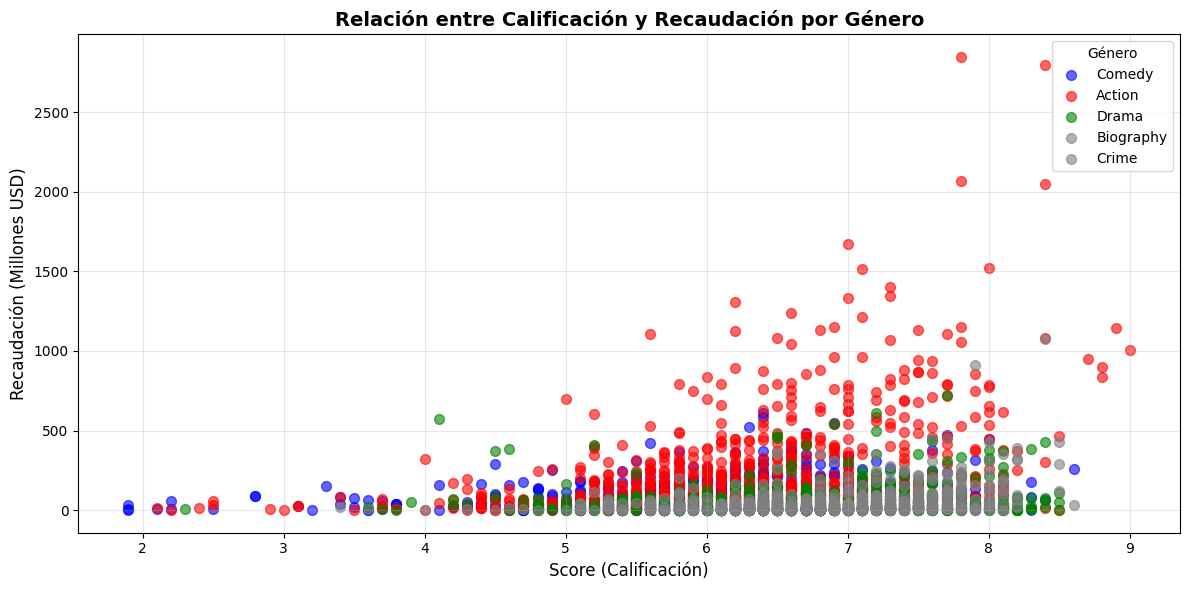

In [0]:
# Gráfico 1: Dispersión para ver la relación entre calificación y recaudación
plt.figure(figsize=(12, 6))  # Creamos una figura de 12x6 pulgadas

# Identificamos los 5 géneros con más películas
top_genres = df_plot['genre'].value_counts().head(5).index
# Diccionario de colores para cada género
colors = {'Action': 'red', 'Comedy': 'blue', 'Drama': 'green', 
          'Adventure': 'orange', 'Animation': 'purple'}

# Creamos un scatter plot (gráfico de puntos) para cada género
for genre in top_genres:
    subset = df_plot[df_plot['genre'] == genre]  # Filtramos películas del género actual
    plt.scatter(subset['score'], subset['gross_millions'],  # X=score, Y=recaudación
                label=genre,  # Etiquetamos para la leyenda
                alpha=0.6,  # Transparencia (0=transparente, 1=opaco)
                s=50,  # Tamaño de los puntos
                color=colors.get(genre, 'gray'))  # Color del género o gris si no está

# Configuramos etiquetas y título
plt.xlabel('Score (Calificación)', fontsize=12)
plt.ylabel('Recaudación (Millones USD)', fontsize=12)
plt.title('Relación entre Calificación y Recaudación por Género', 
          fontsize=14, fontweight='bold')
plt.legend(title='Género')  # Muestramos leyenda
plt.grid(True, alpha=0.3)  # Agregamos cuadrícula semi-transparente
plt.tight_layout()  # Ajustamos para evitar solapamiento
plt.show()  # Mostramos el gráfico

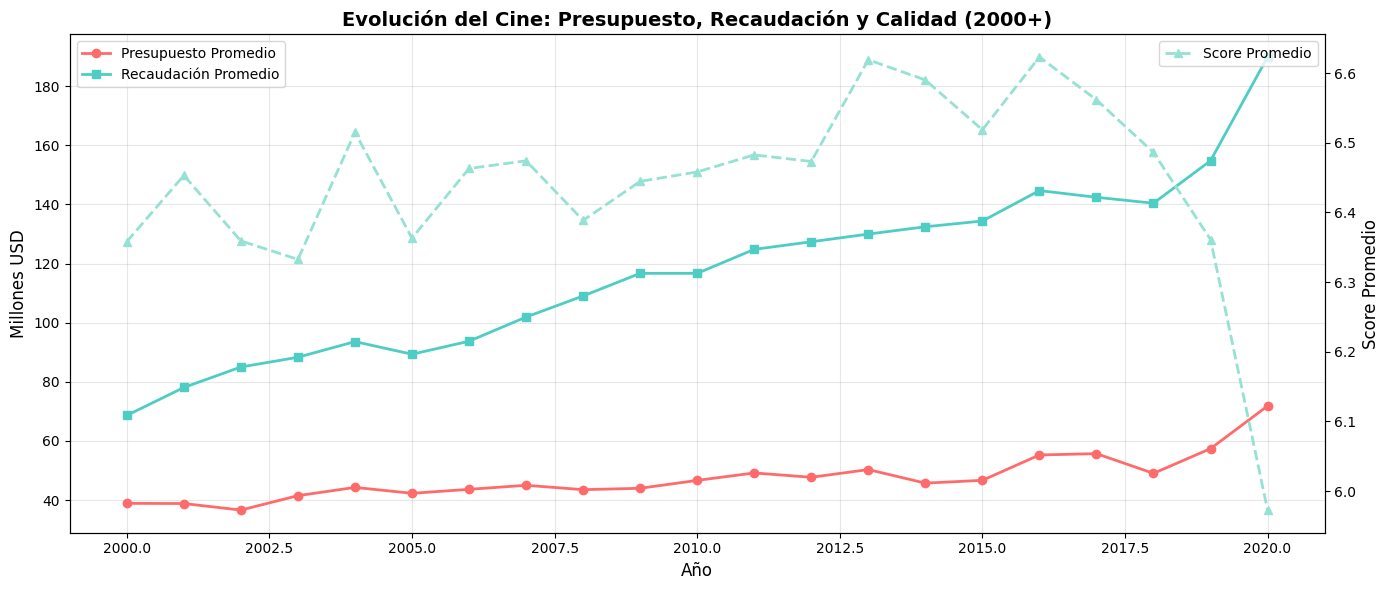

In [0]:
# Gráfico 2: Evolución temporal con doble eje Y (dinero y calidad)
# Agrupamos películas por año y calculamos promedios
df_temporal_plot = df_plot.groupby('year').agg({
    'budget_millions': 'mean',  # Presupuesto promedio por año
    'gross_millions': 'mean',   # Recaudación promedio por año
    'score': 'mean'             # Calificación promedio por año
}).reset_index()  # Convertimos el índice 'year' en columna normal

fig, ax1 = plt.subplots(figsize=(14, 6))  # Creamos figura con eje principal

# Eje izquierdo (ax1): Datos financieros en millones de dólares
ax1.plot(df_temporal_plot['year'], df_temporal_plot['budget_millions'], 
         marker='o', label='Presupuesto Promedio', color='#FF6B6B', linewidth=2)
ax1.plot(df_temporal_plot['year'], df_temporal_plot['gross_millions'], 
         marker='s', label='Recaudación Promedio', color='#4ECDC4', linewidth=2)
ax1.set_xlabel('Año', fontsize=12)
ax1.set_ylabel('Millones USD', fontsize=12)
ax1.legend(loc='upper left')  # Leyenda en esquina superior izquierda
ax1.grid(True, alpha=0.3)  # Cuadrícula

# Eje derecho (ax2): Calificación promedio (escala diferente)
ax2 = ax1.twinx()  # Creamos un segundo eje Y que comparte el mismo eje X
ax2.plot(df_temporal_plot['year'], df_temporal_plot['score'], 
         marker='^', label='Score Promedio', color='#95E1D3', linewidth=2, linestyle='--')
ax2.set_ylabel('Score Promedio', fontsize=12)
ax2.legend(loc='upper right')  # Leyenda en esquina superior derecha

plt.title('Evolución del Cine: Presupuesto, Recaudación y Calidad (2000+)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

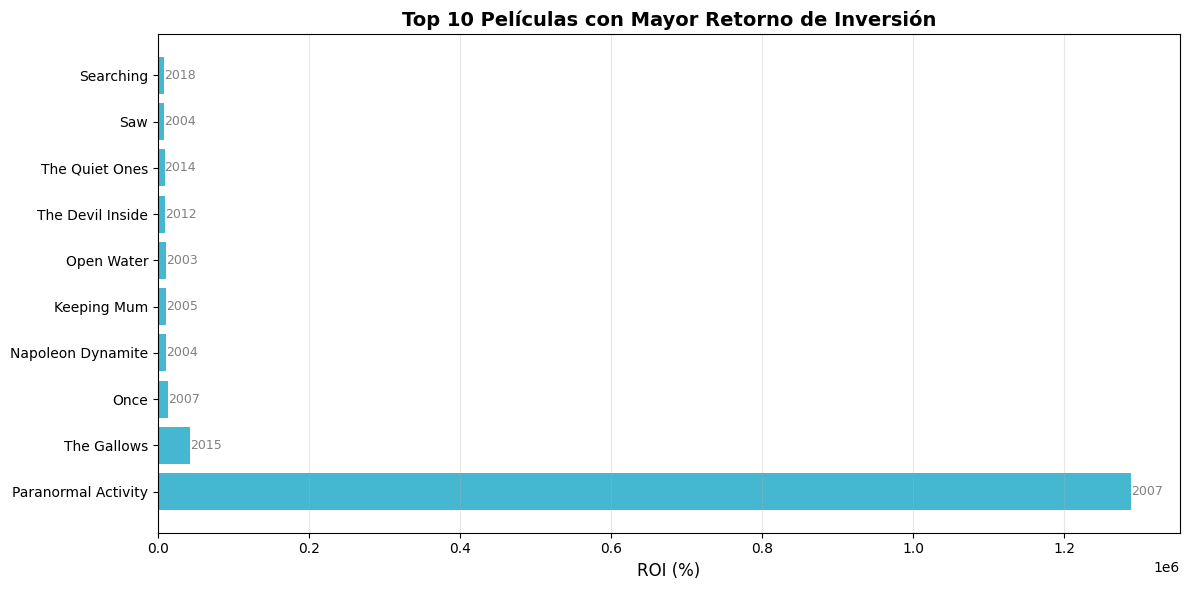

In [0]:
# Gráfico 3: Ranking de películas más rentables según ROI (retorno de inversión)
# nlargest(10, 'roi_percentage'): selecciona las 10 películas con mayor ROI
top_roi = df_plot.nlargest(10, 'roi_percentage')[['name', 'roi_percentage', 'year']]

plt.figure(figsize=(12, 6))
# barh(): gráfico de barras horizontal (más legible para nombres largos)
bars = plt.barh(top_roi['name'], top_roi['roi_percentage'], color='#45B7D1')

# Agrego etiquetas con el año de estreno al lado de cada barra
for i, (idx, row) in enumerate(top_roi.iterrows()):
    # text(): añade texto en posición (x, y)
    plt.text(row['roi_percentage'] + 50, i, f"{int(row['year'])}", 
             va='center',  # Alineación vertical centrada
             fontsize=9, color='gray')

plt.xlabel('ROI (%)', fontsize=12)
plt.title('Top 10 Películas con Mayor Retorno de Inversión', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)  # Cuadrícula solo en eje X
plt.tight_layout()
plt.show()

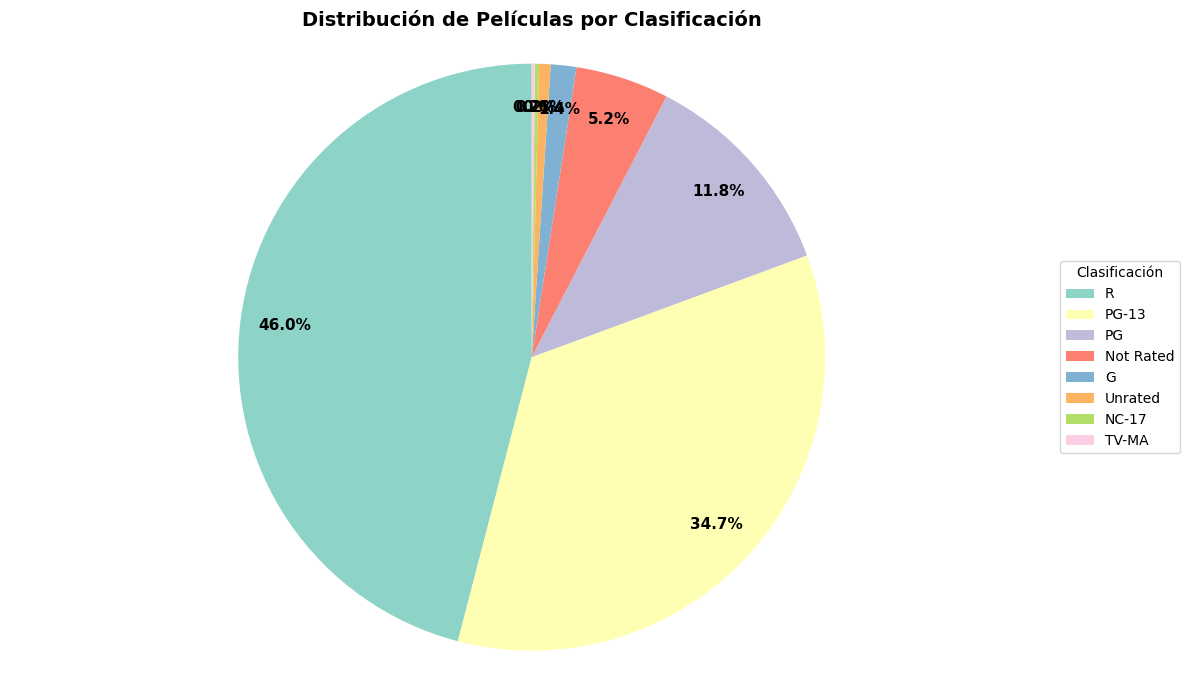

In [0]:
# Gráfico 4: Distribución por clasificación con leyenda externa
rating_counts = df_plot['rating'].value_counts().head(8)

plt.figure(figsize=(12, 7))

# Creamos un gráfico con leyenda separada
wedges, texts, autotexts = plt.pie(
    rating_counts.values,
    labels=None,  # Sin etiquetas en el gráfico (usaremos leyenda)
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    pctdistance=0.85
)

# Configuramos el estilo de porcentajes
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(11)
    autotext.set_weight('bold')

# Agregamos leyenda fuera del círculo
plt.legend(rating_counts.index, 
          title="Clasificación",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),  # Posición fuera del gráfico
          fontsize=10)

plt.title('Distribución de Películas por Clasificación', 
          fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [0]:
# 5.3 - Análisis estadístico

In [0]:
# Análisis de correlaciones entre variables numéricas
    # La correlación mide la relación entre dos variables (-1 a 1)
    # -1 = correlación negativa perfecta, 0 = sin relación, 1 = correlación positiva perfecta
print("=== MATRIZ DE CORRELACIONES ===\n")

numeric_cols = ["score", "votes", "budget_millions", "gross_millions", "runtime"]

# Hacemos un bucle anidado para calcular correlación entre cada par de columnas
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:  # Evitamos duplicados (ej: score-votes y votes-score)
        # Filtramos las filas que tengan ambos valores no nulos
        df_corr = df_delta.filter(
            col(col1).isNotNull() & col(col2).isNotNull()
        )
        
        if df_corr.count() > 0:  # Solo si hay datos para calcular
            corr = df_corr.stat.corr(col1, col2)  # Calculamos el coeficiente de correlación
            print(f"Correlación {col1:20} ↔ {col2:20}: {corr:6.3f}")

=== MATRIZ DE CORRELACIONES ===

Correlación score                ↔ votes               :  0.409
Correlación score                ↔ budget_millions     :  0.076
Correlación score                ↔ gross_millions      :  0.186
Correlación score                ↔ runtime             :  0.399
Correlación votes                ↔ budget_millions     :  0.442
Correlación votes                ↔ gross_millions      :  0.631
Correlación votes                ↔ runtime             :  0.309
Correlación budget_millions      ↔ gross_millions      :  0.740
Correlación budget_millions      ↔ runtime             :  0.321
Correlación gross_millions       ↔ runtime             :  0.245


In [0]:
# Identificar outliers (valores atípicos) en recaudación usando regla de 3 desviaciones estándar
from pyspark.sql.functions import mean, stddev

# Calculamos el promedio y desviación estándar de la recaudación
stats = df_delta.select(
    mean("gross_millions").alias("mean_gross"),  # Promediamos de recaudación (da error pero funciona)
    stddev("gross_millions").alias("std_gross")  # Desviación estándar
).collect()[0]  # collect()[0] obtiene la primera (y única) fila como diccionario

mean_val = stats['mean_gross']  # Valor promedio
std_val = stats['std_gross']    # Desviación estándar
threshold = mean_val + (3 * std_val)  # Umbral: promedio + 3 desviaciones (regla estadística)

# Filtramos las películas que superan el umbral (outliers superiores)
df_outliers = df_delta.filter(col("gross_millions") > threshold)

print(f"=== PELÍCULAS OUTLIERS (Recaudación > {threshold:.2f}M) ===")
print(f"Total de outliers: {df_outliers.count()}")
display(df_outliers.select(
    "name", "year", "genre", "gross_millions", "budget_millions", "roi_percentage"
).orderBy(col("gross_millions").desc()))  # Ordenamos de mayor a menor recaudación

=== PELÍCULAS OUTLIERS (Recaudación > 575.68M) ===
Total de outliers: 169


name,year,genre,gross_millions,budget_millions,roi_percentage
Avatar,2009,Action,2847.25,237.0,1101.37
Avengers: Endgame,2019,Action,2797.5,356.0,685.81
Titanic,1997,Drama,2201.65,200.0,1000.82
Star Wars: Episode VII - The Force Awakens,2015,Action,2069.52,245.0,744.7
Avengers: Infinity War,2018,Action,2048.36,321.0,538.12
The Lion King,2019,Animation,1670.73,260.0,542.59
Jurassic World,2015,Action,1670.52,150.0,1013.68
The Avengers,2012,Action,1518.82,220.0,590.37
Furious 7,2015,Action,1515.34,190.0,697.55
Frozen II,2019,Animation,1450.03,150.0,866.68


In [0]:
# Análisis de rentabilidad según el rango de presupuesto de las películas
# Creamos vista temporal para ejecutar consulta SQL
df_delta.createOrReplaceTempView("peliculas_analisis")

display(spark.sql("""
    SELECT 
        -- Clasificar películas en rangos de presupuesto usando CASE
        CASE 
            WHEN budget_millions < 10 THEN 'Bajo (< $10M)'
            WHEN budget_millions < 50 THEN 'Medio ($10-50M)'
            WHEN budget_millions < 100 THEN 'Alto ($50-100M)'
            ELSE 'Muy Alto (> $100M)'
        END as rango_presupuesto,
        COUNT(*) as cantidad,  -- Cantidad de películas en cada rango
        ROUND(AVG(score), 2) as score_promedio,  -- Calificación promedio
        ROUND(AVG(roi_percentage), 2) as roi_promedio,  -- Rentabilidad promedia
        ROUND(AVG(gross_millions), 2) as recaudacion_promedio  -- Recaudación promedio
    FROM peliculas_analisis
    WHERE budget_millions IS NOT NULL AND gross_millions IS NOT NULL  -- Solo con datos completos
    GROUP BY 
        -- Agrupamos por los mismos rangos definidos arriba
        CASE 
            WHEN budget_millions < 10 THEN 'Bajo (< $10M)'
            WHEN budget_millions < 50 THEN 'Medio ($10-50M)'
            WHEN budget_millions < 100 THEN 'Alto ($50-100M)'
            ELSE 'Muy Alto (> $100M)'
        END
    ORDER BY 
        -- Ordenamos de menor a mayor presupuesto (Bajo → Muy Alto)
        CASE 
            WHEN rango_presupuesto = 'Bajo (< $10M)' THEN 1
            WHEN rango_presupuesto = 'Medio ($10-50M)' THEN 2
            WHEN rango_presupuesto = 'Alto ($50-100M)' THEN 3
            ELSE 4
        END
"""))

rango_presupuesto,cantidad,score_promedio,roi_promedio,recaudacion_promedio
Bajo (< $10M),1237,6.45,1932.96,18.93
Medio ($10-50M),2948,6.34,168.4,61.06
Alto ($50-100M),811,6.35,156.67,175.48
Muy Alto (> $100M),440,6.65,214.57,486.83
